<a href="https://colab.research.google.com/github/shadatshohan/Android-Attendence-System/blob/master/3layer95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from matplotlib import pyplot as plt

import numpy as np
import glob
import os
import keras
from keras.layers import Convolution2D,MaxPooling2D,BatchNormalization,Flatten,Dense,Dropout
from keras.models import Sequential
os.environ['KERAS_BACKEND']='tensorflow'

path='/content/drive/MyDrive/Training2/*'
train_images = []
train_labels = [] 
count=0
SIZE=128
for directory_path in glob.glob(path):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        print(count)
        count+=1
        img = cv2.imread(img_path)
        img=cv2.resize(img,(SIZE,SIZE))
        train_images.append(img)
        train_labels.append(label) 

train_images=np.array(train_images)
train_labels=np.array(train_labels)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

Streaming output truncated to the last 5000 lines.
661
/content/drive/MyDrive/Training2/meningioma_tumor/m (172).jpg
662
/content/drive/MyDrive/Training2/meningioma_tumor/m3 (112).jpg
663
/content/drive/MyDrive/Training2/meningioma_tumor/m3 (55).jpg
664
/content/drive/MyDrive/Training2/meningioma_tumor/m2 (37).jpg
665
/content/drive/MyDrive/Training2/meningioma_tumor/m2 (67).jpg
666
/content/drive/MyDrive/Training2/meningioma_tumor/m1(162).jpg
667
/content/drive/MyDrive/Training2/meningioma_tumor/m2 (66).jpg
668
/content/drive/MyDrive/Training2/meningioma_tumor/m1(134).jpg
669
/content/drive/MyDrive/Training2/meningioma_tumor/m (121).jpg
670
/content/drive/MyDrive/Training2/meningioma_tumor/m1(5).jpg
671
/content/drive/MyDrive/Training2/meningioma_tumor/m1(179).jpg
672
/content/drive/MyDrive/Training2/meningioma_tumor/m (27).jpg
673
/content/drive/MyDrive/Training2/meningioma_tumor/m (140).jpg
674
/content/drive/MyDrive/Training2/meningioma_tumor/m1(24).jpg
675
/content/drive/MyDrive/T

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, input_shape = (SIZE, SIZE, 3),data_format='channels_last'))
feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
feature_extractor.add(BatchNormalization(axis=-1))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(64, 5, activation = activation))
feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
feature_extractor.add(BatchNormalization(axis=-1))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(64, 5, activation = activation, padding = 'same'))
feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
feature_extractor.add(BatchNormalization(axis=-1))
feature_extractor.add(Dropout(0.2))


feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(512, activation = activation)(x)
x=BatchNormalization(axis=-1)(x)
x=Dropout(0.2)(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

##########################################
#Train the CNN model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train,X_test,y_train,y_test=train_test_split(train_images,train_labels_encoded,test_size=0.2,random_state=0)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
history=cnn_model.fit(X_train,y_train_one_hot,batch_size=64,verbose=1,epochs=200,validation_split=0.1,shuffle=False)
print("Test_Accuracy: {:.2f}%".format(cnn_model.evaluate(X_test,y_test_one_hot)[1]*100))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0     

In [6]:
# Machine learning portion
X_for_RF = feature_extractor.predict(X_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 40, random_state = 42)
RF_model.fit(X_for_RF, y_train)

from sklearn import svm
SVM_model = svm.SVC(kernel='rbf',decision_function_shape='ovo',C=10,probability=True)  #For multiclass classification
SVM_model.fit(X_for_RF, y_train)


#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(X_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
prediction_SVM=SVM_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
# prediction_RF = le.inverse_transform(prediction_RF)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM))

Accuracy =  0.8876582278481012
Accuracy =  0.9572784810126582


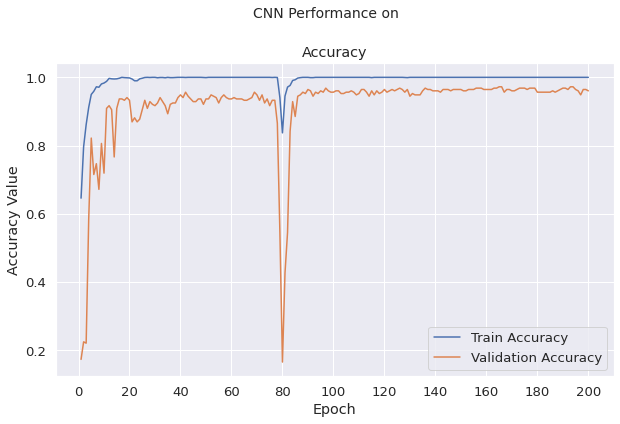

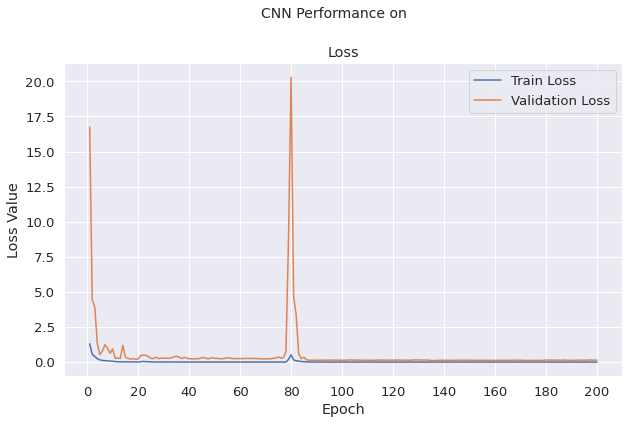

In [7]:
# loss and accuracy variance
f,ax1 = plt.subplots(1,figsize=(10, 6))
t = f.suptitle('CNN Performance on', fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, max_epoch, 20))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax1.figure.savefig('accuracy_variance.png')

f1,ax2 = plt.subplots(1,figsize=(10, 6))
t = f1.suptitle('CNN Performance on', fontsize=14)
f1.subplots_adjust(top=0.85, wspace=0.3)
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, max_epoch, 20))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax2.figure.savefig('loss_variance.png')

              precision    recall  f1-score   support

      glioma       0.94      0.96      0.95       180
  meningioma       0.97      0.93      0.95       187
    no tumor       0.94      0.94      0.94        88
   pituitary       0.98      0.99      0.99       177

    accuracy                           0.96       632
   macro avg       0.96      0.96      0.96       632
weighted avg       0.96      0.96      0.96       632



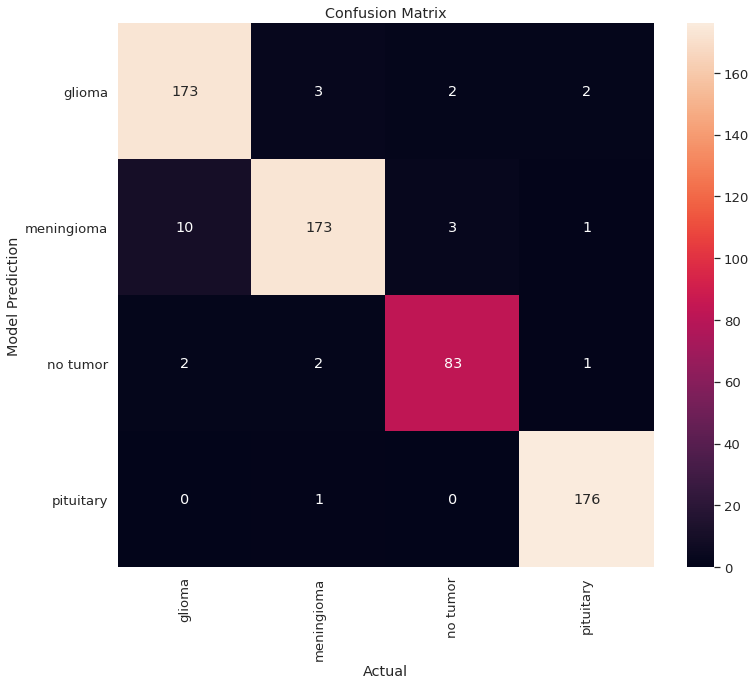

In [8]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test,SVM_model.predict(X_test_feature))


fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.set(font_scale=1.2)
axes=sns.heatmap(cm, annot=True, ax=ax,fmt='.3g')
class_labels = ['glioma','meningioma','no tumor','pituitary']

axes.set_xlabel('Actual')
axes.set_ylabel('Model Prediction')

tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=90)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

axes.set_title('Confusion Matrix')
axes.figure.savefig("confusion_matrix.png")

# classification report
from sklearn.metrics import classification_report
report=classification_report(y_test,SVM_model.predict(X_test_feature),target_names=class_labels)
print(report)

0.9929777715178615 0.9819317105120208 0.9885791053657719


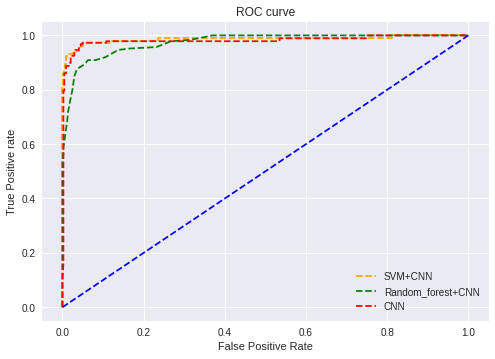

In [9]:
# ROC-AUC method comparison
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred_prob1=SVM_model.predict_proba(X_test_feature)
pred_prob2=RF_model.predict_proba(X_test_feature)
pred_prob3=cnn_model.predict(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1,multi_class='ovo')
auc_score2 = roc_auc_score(y_test, pred_prob2,multi_class='ovo')
auc_score3 = roc_auc_score(y_test, pred_prob3,multi_class='ovo')
print(auc_score1, auc_score2,auc_score3)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVM+CNN')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Random_forest+CNN')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='CNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_method_comparison',dpi=300)
plt.show();

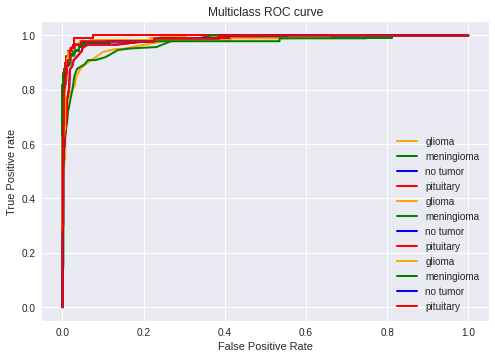

In [10]:
# ROC-AUC class comparison
fpr1 = {}
tpr1 = {}
thresh1 ={}
n_class = 4
for i in range(n_class):    
    fpr1[i], tpr1[i], thresh1[i] = roc_curve(y_test, pred_prob1[:,i], pos_label=i)    
# plotting    
plt.plot(fpr1[0], tpr1[0],linewidth=2,color='orange', label='glioma')
plt.plot(fpr1[1], tpr1[1],linewidth=2,color='green', label='meningioma')
plt.plot(fpr1[2], tpr1[2],linewidth=2,color='blue', label='no tumor')
plt.plot(fpr1[2], tpr1[2],linewidth=2,color='red', label='pituitary')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC_svm',dpi=300)

fpr2 = {}
tpr2 = {}
thresh2 ={}

n_class = 4

for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_test, pred_prob2[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr2[0], tpr2[0],linewidth=2,color='orange', label='glioma')
plt.plot(fpr2[1], tpr2[1],linewidth=2,color='green', label='meningioma')
plt.plot(fpr2[2], tpr2[2],linewidth=2,color='blue', label='no tumor')
plt.plot(fpr2[2], tpr2[2],linewidth=2,color='red', label='pituitary')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC_rf',dpi=300)

fpr3 = {}
tpr3 = {}
thresh3 ={}

n_class = 4

for i in range(n_class):    
    fpr3[i], tpr3[i], thresh3[i] = roc_curve(y_test, pred_prob3[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr3[0], tpr3[0],linewidth=2,color='orange', label='glioma')
plt.plot(fpr3[1], tpr3[1],linewidth=2,color='green', label='meningioma')
plt.plot(fpr3[2], tpr3[2],linewidth=2,color='blue', label='no tumor')
plt.plot(fpr3[2], tpr3[2],linewidth=2,color='red', label='pituitary')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC_cnn',dpi=300)